In [1]:
from anndata import AnnData
from GraphST.graphst import GraphST
import squidpy as sq
from GraphST.utils import clustering
from GraphST.model import BaseEncoder, ExplainableEncoder
import numpy as np
import pandas as pd
import torch
from torch_geometric.explain import Explainer, GNNExplainer, Explanation
from torch_geometric.utils import dense_to_sparse
import time
import pickle
from main import *
from distilled_decoder import DistilledDecoder, ClusterPredictor
from importlib import reload
import matplotlib.pyplot as plt

/home/amintehrani/.pyenv/versions/torchgeo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/amintehrani/.pyenv/versions/torchgeo/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/amintehrani/.pyenv/versions/torchgeo/lib/python3.12/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)


In [2]:
base_encoder_path="graphst_base_encoder.pt"
distilled_decoder_path="best_distilled_decoder.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Base encoder path:", base_encoder_path)
print("Distilled decoder path:", distilled_decoder_path)
print("Device:", device)

Base encoder path: graphst_base_encoder.pt
Distilled decoder path: best_distilled_decoder.pt
Device: cuda


In [3]:
adata = load_dataset_V1_Human_Lymph_Node()
annotate_graphclusters_V1_Human_Lymph_Node(adata)

adata

/home/amintehrani/.pyenv/versions/torchgeo/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/amintehrani/.pyenv/versions/torchgeo/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4035 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'graphclust'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
gst = get_graphst(adata)
base_encoder = load_graphst_base_encoder(gst, base_encoder_path).to(device)
edge_index, _ = dense_to_sparse(gst.adj)

/home/amintehrani/.pyenv/versions/torchgeo/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
# Clustering

# apply_clustering(graphst.gadata, method="leiden", n_clusters=7)
clustering_key = "graphclust"

clusters: pd.Series = gst.adata.obs[clustering_key]

In [ ]:
decoder = DistilledDecoder(gst.dim_output, clusters.nunique()).to(device)
decoder.load_state_dict(torch.load("best_distilled_decoder.pt"))

cluster_predictor = ClusterPredictor(base_encoder, decoder).to(device)

In [ ]:
res = base_encoder(gst.features, gst.features_a, gst.adj)

In [ ]:
explainer1_name = "explainer1_cluster_250"

explainer1 = Explainer(
    model=cluster_predictor,
    algorithm=GNNExplainer(epochs=250),
    **(explainer1_spec:= dict(
    explanation_type='phenomenon',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
    ))
)

# clusters = torch.argmax(cluster_predictor(gst.features, edge_index), dim=1)
# res = explainer1(gst.features, edge_index, target=clusters)
# save_explanations(explainer1_spec, explainer1_name, 250, res)

In [9]:
explainer2_name = "explainer2_cluster_250"

explainer2 = Explainer(
    model=cluster_predictor,
    algorithm=GNNExplainer(epochs=250),
    **(explainer2_spec:= dict(
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
    ))
)

# res2 = explainer2(gst.features, edge_index)
# save_explanations(explainer2_spec, explainer2_name, 250, res2)

In [8]:
from GraphST import model
reload(model)
from GraphST.model import ExplainableEncoder


In [25]:
def default_similarity_fn(hiden_emb: torch.Tensor, h: torch.Tensor, ret: torch.Tensor, ret_a: torch.Tensor, emb: torch.Tensor, emb_a: torch.Tensor):
        print(ret[:,0].mean(), ret[:,1].mean())
        print(ret_a[:,0].mean(), ret_a[:,1].mean())
        
        print(hiden_emb.shape, h.shape, ret.shape, ret_a.shape, emb.shape, emb_a.shape )

default_similarity_fn(*res)

tensor(1.1282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-0.8385, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([4035, 64]) torch.Size([4035, 3001]) torch.Size([4035, 2]) torch.Size([4035, 2]) torch.Size([4035, 64]) torch.Size([4035, 64])


In [7]:
explainer3_name = "explainer3_self"

def similarity_fn(hiden_emb, h, ret, ret_a, emb, emb_a):
        return hiden_emb @ hiden_emb.T


explainer3 = Explainer(
    model=ExplainableEncoder(base_encoder, gst.features_a, sim_func=similarity_fn).to(device),
    algorithm=GNNExplainer(epochs=250),
    **(explainer3_spec:= dict(
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
    ))
)

res3 = explainer3(gst.features, edge_index)
save_explanations(explainer3_spec, explainer3_name, 250, res3)

'explanations/explainer3_self_epochs_250'

In [8]:
exp1: Explanation
exp1, _ = load_explanations("explainer1_cluster_250_epochs_250")

In [22]:
exp2: Explanation
exp2, _ = load_explanations("explainer2_cluster_250_epochs_250")

In [8]:
exp3: Explanation
exp3, _ = load_explanations("explainer3_self_epochs_250")

In [9]:
import torch

def adaptive_threshold(values, method="percentile", **kwargs):
    x = torch.tensor(values, dtype=torch.float32)

    if method == "percentile":
        q = kwargs.get("q", 0.9)  # default = 90th percentile
        thresh = torch.quantile(x, q)
    
    elif method == "mad":
        median = torch.median(x)
        mad = torch.median(torch.abs(x - median))
        k = kwargs.get("k", 3.0)
        thresh = median + k * mad
    
    elif method == "zscore":
        mean, std = torch.mean(x), torch.std(x)
        k = kwargs.get("k", 2.0)
        thresh = mean + k * std
    
    elif method == "otsu":
        hist = torch.histc(x, bins=100, min=float(x.min()), max=float(x.max()))
        total = x.numel()
        sum_total = torch.arange(1, 101, dtype=torch.float32) @ hist
        sumB, wB, wF, varMax, thresh_bin = 0.0, 0.0, 0.0, 0.0, 0
        for i in range(100):
            wB += hist[i]
            if wB == 0: continue
            wF = total - wB
            if wF == 0: break
            sumB += i * hist[i]
            mB = sumB / wB
            mF = (sum_total - sumB) / wF
            varBetween = wB * wF * (mB - mF) ** 2
            if varBetween > varMax:
                varMax = varBetween
                thresh_bin = i
        bin_width = (x.max() - x.min()) / 100
        thresh = x.min() + thresh_bin * bin_width
    
    else:
        raise ValueError(f"Unknown method {method}")
    
    # Apply threshold
    filtered = torch.where(x >= thresh, x, torch.tensor(0.0))
    return thresh.item(), filtered

# Example usage
# values = [0.1, 0.2, 0.5, 1.0, 3.2, 3.5, 4.0, 10.0]
# thresh, filtered = adaptive_threshold(values, method="percentile", q=0.8)
# print("Threshold:", thresh)
# print("Filtered values:", filtered.tolist())


Threshold: 0.35287562012672424
Count: 22


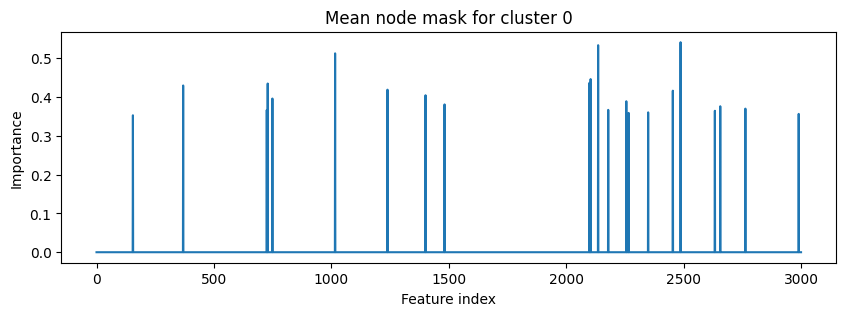

Threshold: 0.4315473735332489
Count: 7


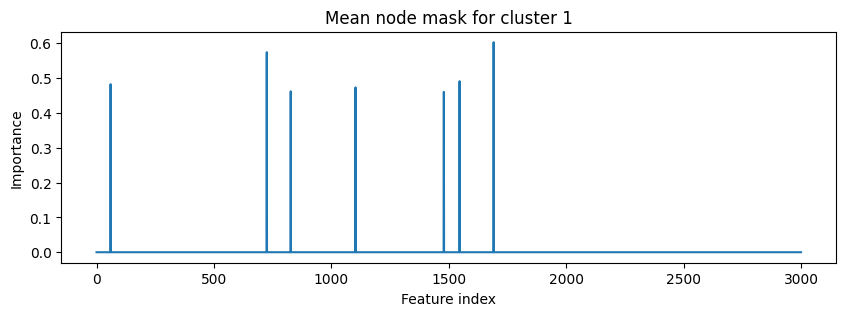

Threshold: 0.4119780659675598
Count: 25


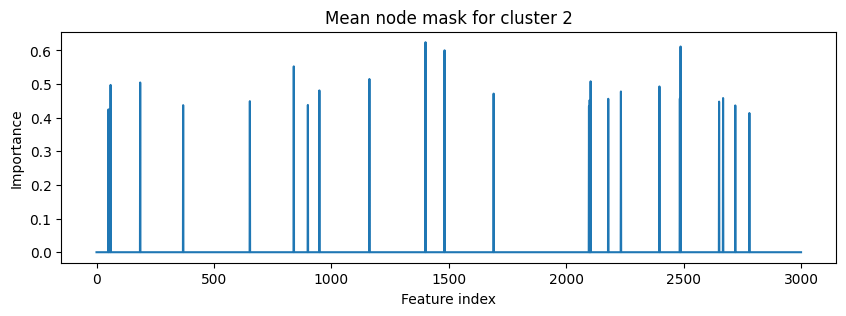

Threshold: 0.3186613917350769
Count: 22


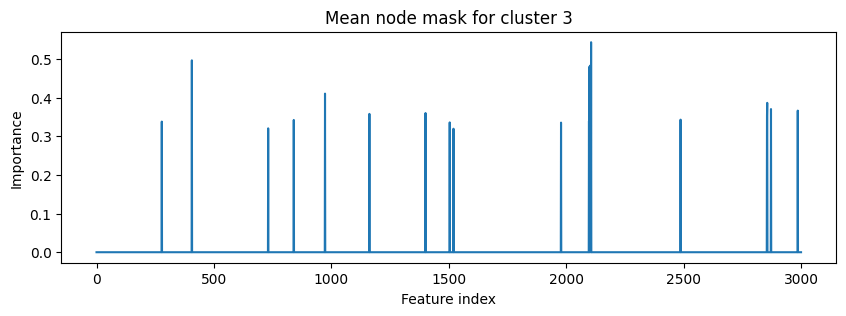

Threshold: 0.30044788122177124
Count: 17


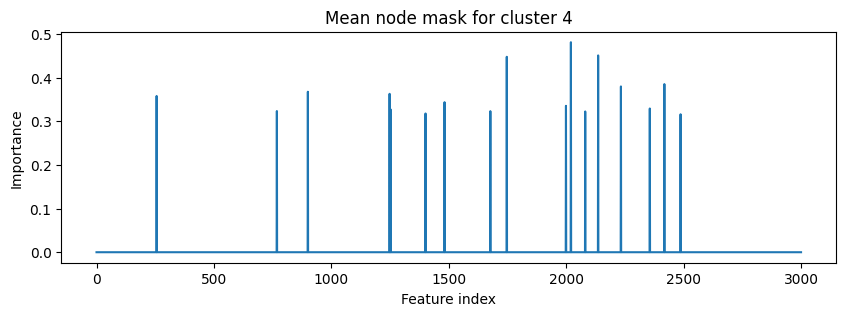

Threshold: 0.30009061098098755
Count: 23


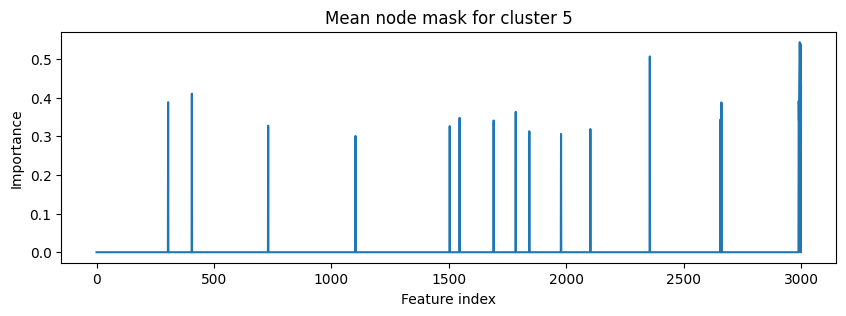

Threshold: 0.3146016001701355
Count: 6


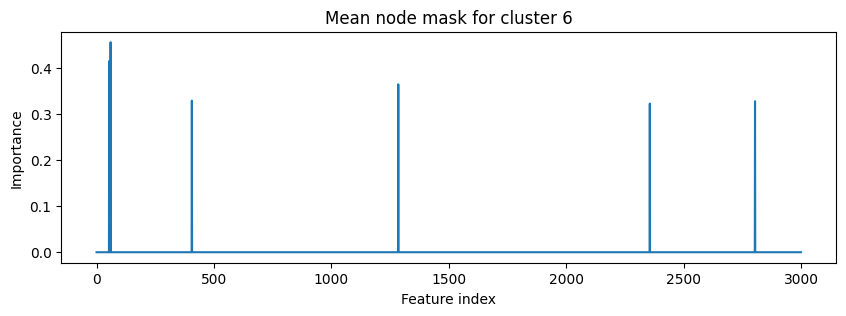

graphclust
0    [tensor(0.0171), tensor(0.0713), tensor(0.1195...
1    [tensor(0.0456), tensor(0.1004), tensor(0.1321...
2    [tensor(0.0127), tensor(0.0817), tensor(0.1290...
3    [tensor(0.0082), tensor(0.0637), tensor(0.1207...
4    [tensor(0.0048), tensor(0.0693), tensor(0.1122...
5    [tensor(0.0120), tensor(0.0654), tensor(0.1283...
6    [tensor(0.0082), tensor(0.0445), tensor(0.1053...
Name: graphclust, dtype: object


In [82]:

_clusters = clusters.reset_index(drop=True)
cluster_groups = _clusters.groupby(_clusters)
# Aggregate exp2.node_mask for all nodes in each cluster
# exp2.node_mask shape: [num_nodes, num_features]
# clusters_ is the cluster assignment for each node (reset index)

# Compute mean node_mask per cluster

cluster_node_mask_means = cluster_groups.apply(lambda idxs: exp2.node_mask[idxs.index].cpu().mean(dim=0))

# cluster_node_mask_means is a Series where each value is a tensor or list of tensors
for cluster_id, mean_mask in cluster_node_mask_means.items():
    # Convert to numpy for plotting if needed
    if hasattr(mean_mask, 'cpu'):
        mean_mask_np = mean_mask.cpu().numpy()
    elif isinstance(mean_mask, list):
        mean_mask_np = np.array([x.item() if hasattr(x, 'item') else x for x in mean_mask])
    else:
        mean_mask_np = np.array(mean_mask)
    plt.figure(figsize=(10, 3))
    threshold, data = adaptive_threshold(mean_mask_np.reshape(-1, 1), method="zscore", k=3.5)
    print("Threshold:", threshold)
    print("Count:", (data > 0).sum().item())
    plt.plot(data)
    plt.title(f"Mean node mask for cluster {cluster_id}")
    plt.xlabel("Feature index")
    plt.ylabel("Importance")
    plt.show()

print(cluster_node_mask_means)
# for (cluster_id, group) in cluster_groups.groups:
#     print(f"Cluster {cluster_id}: {group}")

# Get edges connected to node i
edges = exp2.edge_index
edge_mask = exp2.edge_mask

# print(exp2.node_mask.shape)

# # Find edges where node i is the source or target
# connected = (edges[0] == i) | (edges[1] == i)

# important_edges = torch.where(connected)[0]
# print(important_edges)


# # Sort by importance
# sorted_idx = important_edges[edge_mask[important_edges].argsort(descending=True)]

# # # Show top 5 important neighbors
# # for idx in sorted_idx[:5]:
# #     src, tgt = edges[:, idx].tolist()
# #     neighbor = tgt if src == i else src
# #     print(f"Neighbor: {neighbor}, Importance: {edge_mask[idx].item():.4f}")

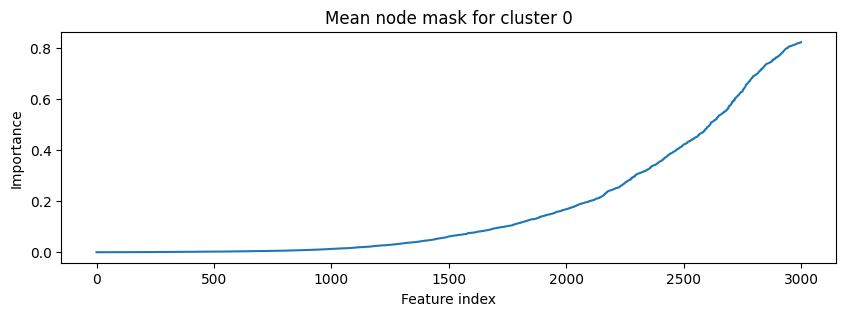

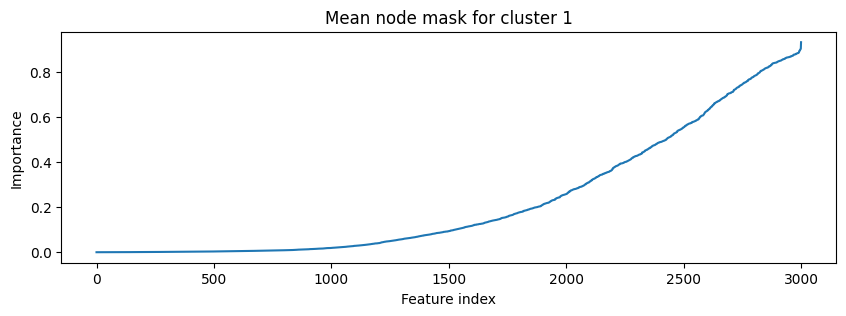

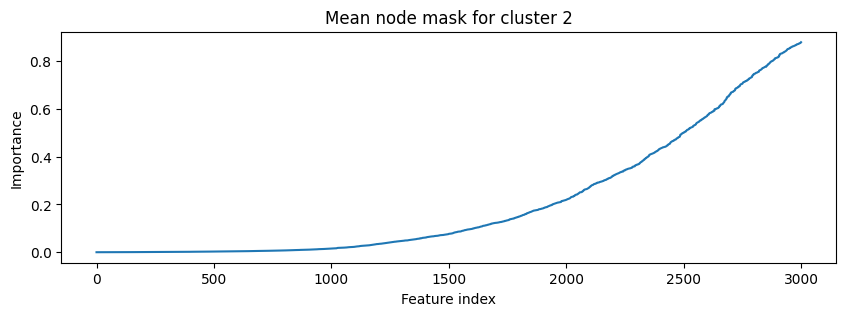

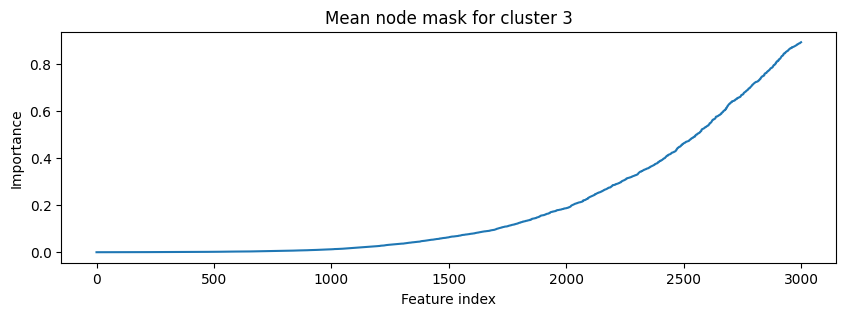

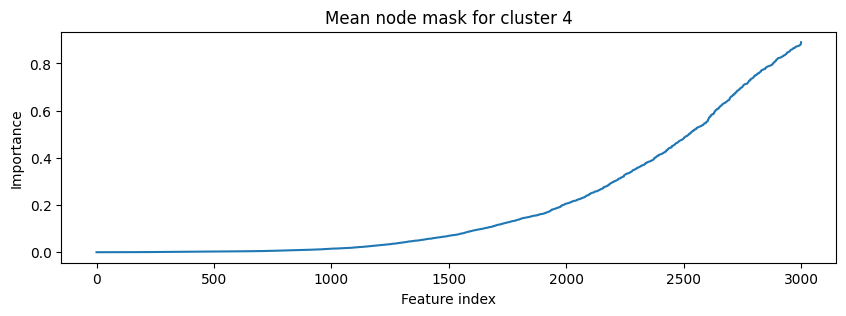

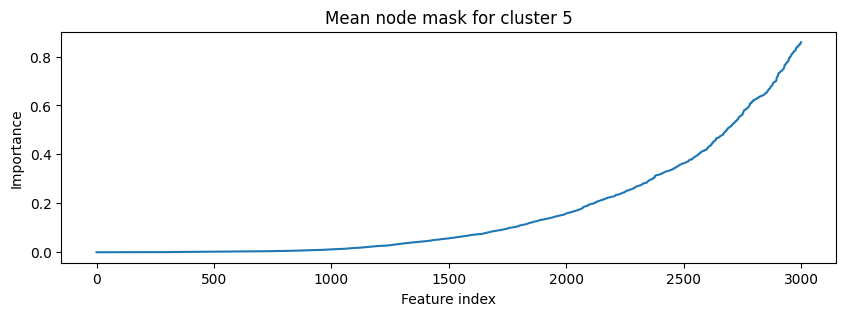

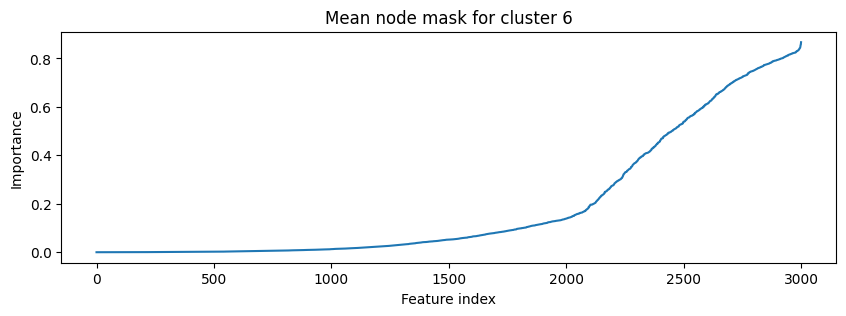

graphclust
0    [tensor(0.0417), tensor(0.0785), tensor(0.6134...
1    [tensor(0.0874), tensor(0.1306), tensor(0.6900...
2    [tensor(0.0414), tensor(0.1037), tensor(0.6672...
3    [tensor(0.0265), tensor(0.0945), tensor(0.6257...
4    [tensor(0.0205), tensor(0.1057), tensor(0.6962...
5    [tensor(0.0322), tensor(0.0794), tensor(0.5327...
6    [tensor(0.0168), tensor(0.0477), tensor(0.5909...
Name: graphclust, dtype: object


In [10]:

_clusters = clusters.reset_index(drop=True)
cluster_groups = _clusters.groupby(_clusters)
# Aggregate exp2.node_mask for all nodes in each cluster
# exp2.node_mask shape: [num_nodes, num_features]
# clusters_ is the cluster assignment for each node (reset index)

# Compute mean node_mask per cluster

cluster_node_mask_means = cluster_groups.apply(lambda idxs: exp3.node_mask[idxs.index].cpu().mean(dim=0))

# cluster_node_mask_means is a Series where each value is a tensor or list of tensors
for cluster_id, mean_mask in cluster_node_mask_means.items():
    # Convert to numpy for plotting if needed
    if hasattr(mean_mask, 'cpu'):
        mean_mask_np = mean_mask.cpu().numpy()
    elif isinstance(mean_mask, list):
        mean_mask_np = np.array([x.item() if hasattr(x, 'item') else x for x in mean_mask])
    else:
        mean_mask_np = np.array(mean_mask)
    plt.figure(figsize=(10, 3))
    # threshold, data = adaptive_threshold(mean_mask_np.reshape(-1, 1), method="zscore", k=3.5)
    # print("Threshold:", threshold)
    # print("Count:", (data > 0).sum().item())
    plt.plot(sorted(mean_mask_np))
    plt.title(f"Mean node mask for cluster {cluster_id}")
    plt.xlabel("Feature index")
    plt.ylabel("Importance")
    plt.show()

print(cluster_node_mask_means)
# for (cluster_id, group) in cluster_groups.groups:
#     print(f"Cluster {cluster_id}: {group}")

# Get edges connected to node i
edges = exp3.edge_index
edge_mask = exp3.edge_mask

# print(exp2.node_mask.shape)

# # Find edges where node i is the source or target
# connected = (edges[0] == i) | (edges[1] == i)

# important_edges = torch.where(connected)[0]
# print(important_edges)


# # Sort by importance
# sorted_idx = important_edges[edge_mask[important_edges].argsort(descending=True)]

# # # Show top 5 important neighbors
# # for idx in sorted_idx[:5]:
# #     src, tgt = edges[:, idx].tolist()
# #     neighbor = tgt if src == i else src
# #     print(f"Neighbor: {neighbor}, Importance: {edge_mask[idx].item():.4f}")